In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import matplotlib as mpl
import json
import pickle
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
# for VS code plotting
# mpl.rcParams.update(_VSCode_defaultMatplotlib_Params)
#sns.set_style(rc = {'figure.facecolor':'white'})

import plotly.express as px
%matplotlib inline

In [3]:
# read in data for india
df = pd.read_csv('data/INvideos.csv', parse_dates=['trending_date', 'publish_time'])
df.head()

video_id trending_date  \
0  kzwfHumJyYc      17.14.11   
1  zUZ1z7FwLc8      17.14.11   
2  10L1hZ9qa58      17.14.11   
3  N1vE8iiEg64      17.14.11   
4  kJzGH0PVQHQ      17.14.11   

                                               title    channel_title  \
0  Sharry Mann: Cute Munda ( Song Teaser) | Parmi...  Lokdhun Punjabi   
1  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...          HJ NEWS   
2  Stylish Star Allu Arjun @ ChaySam Wedding Rece...             TFPC   
3                     Eruma Saani | Tamil vs English      Eruma Saani   
4  why Samantha became EMOTIONAL @ Samantha naga ...       Filmylooks   

   category_id              publish_time  \
0            1 2017-11-12 12:20:39+00:00   
1           25 2017-11-13 05:43:56+00:00   
2           24 2017-11-12 15:48:08+00:00   
3           23 2017-11-12 07:08:48+00:00   
4           24 2017-11-13 01:14:16+00:00   

                                                tags    views  likes  \
0  sharry mann|"sharry mann new song"|"sharry man...  1096327  33966   
1  पीरियड्स के समय|"पेट पर पति करता ऐसा"|"देखकर द...   590101    735   
2  Stylish Star Allu Arjun @ ChaySam Wedding Rece...   473988   2011   
3  Eruma Saani|"Tamil Comedy Videos"|"Films"|"Mov...  1242680  70353   
4  Filmylooks|"latest news"|"telugu movies"|"telu...   464015    492   

   dislikes  comment_count                                  thumbnail_link  \
0       798            882  https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg   
1       904              0  https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg   
2       243            149  https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg   
3      1624           2684  https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg   
4       293             66  https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1               True             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description  
0  Presenting Sharry Mann latest Punjabi Song  Cu...  
1  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...  
2  Watch Stylish Star Allu Arjun @ ChaySam Weddin...  
3  This video showcases the difference between pe...  
4  why Samantha became EMOTIONAL @ Samantha naga ...

In [4]:
# parse trending date
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
video_id                  37352 non-null object
trending_date             37352 non-null datetime64[ns]
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null datetime64[ns, UTC]
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               36791 non-null object
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64(5), object(6)
memory usage: 3.8+ MB


In [5]:
# drop duplicate rows
print(f'shape before dropping duplicates - {df.shape}')
df = df.drop_duplicates()
print(f'shape after dropping duplicates - {df.shape}')

shape before dropping duplicates - (37352, 16)
shape after dropping duplicates - (33089, 16)


In [6]:
# read in category mapping json
with open('data/IN_category_id.json') as file:
    cat_map = json.load(file) 

In [7]:
# preprocess category mapping to pull in category id vs title
df_cat_map = pd.DataFrame()
num_categories = df.category_id.unique().shape[0]
df_cat_map['category_id'] = ['']*num_categories
df_cat_map['category_title'] = ['']*num_categories
for i,x in enumerate(cat_map['items']):
    df_cat_map.loc[i, 'category_id'] = x['id']
    df_cat_map.loc[i, 'category_title'] = x['snippet']['title']
df_cat_map['category_id'] = df_cat_map['category_id'].astype(np.int8)

In [8]:
# pull in category name into the base dataframe
df = df.merge(df_cat_map, how='left', on='category_id')
df.shape

(33089, 17)

In [9]:
df.category_title.isnull().sum()

103

In [10]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33089 entries, 0 to 33088
Data columns (total 17 columns):
video_id                  33089 non-null object
trending_date             33089 non-null datetime64[ns]
title                     33089 non-null object
channel_title             33089 non-null object
category_id               33089 non-null int64
publish_time              33089 non-null datetime64[ns, UTC]
tags                      33089 non-null object
views                     33089 non-null int64
likes                     33089 non-null int64
dislikes                  33089 non-null int64
comment_count             33089 non-null int64
thumbnail_link            33089 non-null object
comments_disabled         33089 non-null bool
ratings_disabled          33089 non-null bool
video_error_or_removed    33089 non-null bool
description               32562 non-null object
category_title            32986 non-null object
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64

### Create new features

In [11]:
# days from publish to trending
df['days_to_trending'] = (df['trending_date'] - pd.to_datetime(df['publish_time'].dt.date)).dt.days

In [12]:
# get unique list of tags
list_unique_tag_combo = df.tags.unique()
individual_tags = set()
print(f'# Unique tag combinations: {len(list_unique_tag_combo)}')
for y in tqdm(list_unique_tag_combo):
    individual_tags = individual_tags | set([x.replace('"','') for x in y.split('|')])
list_individual_tags = list(individual_tags)
print(f'# unique tags:{len(list_individual_tags)}')

100%|██████████| 12578/12578 [00:47<00:00, 265.46it/s]# unique tags:101406



In [13]:
df_tag_unique = df.groupby(['tags'])['video_id'].count().reset_index().rename(columns={'video_id':'num_videos'})

In [14]:
cv = CountVectorizer()
t = pd.DataFrame(cv.fit_transform(df_tag_unique.tags.fillna('').str.replace(r'\|', ' ')).A,columns=cv.get_feature_names())

In [15]:
t.head()

00  000  007  00pm  01  01015  010418  01st  01t20  01t21  ...  ർള  ർവ  \
0   0    0    0     0   0      0       0     0      0      0  ...   0   0   
1   0    0    0     0   0      0       0     0      0      0  ...   0   0   
2   0    0    0     0   0      0       0     0      0      0  ...   0   0   
3   0    0    0     0   0      0       0     0      0      0  ...   0   0   
4   0    0    0     0   0      0       0     0      0      0  ...   0   0   

   ർവത  ർഷ  ർസ  ൽഖറ  ൽഫ  ൽമ  ൽസണ  担担面  
0    0   0   0    0   0   0    0    0  
1    0   0   0    0   0   0    0    0  
2    0   0   0    0   0   0    0    0  
3    0   0   0    0   0   0    0    0  
4    0   0   0    0   0   0    0    0  

[5 rows x 31067 columns]

In [16]:
t.shape

(12578, 31067)

In [17]:
np.broadcast_to(df_tag_unique['num_videos'].values.flatten, (df_tag_unique.shape[0], 31067)).shape

(12578, 31067)

In [18]:
# min number of occurences of keyword in tags across all videos (1% of # videos)
df.shape[0]*0.01

330.89

In [19]:
tag_word_total_occurences = np.multiply(t.values,np.broadcast_to(df_tag_unique['num_videos'].values.reshape(df_tag_unique.shape[0], 1), (df_tag_unique.shape[0], 31067)))

In [20]:
most_frequent_words_tags = t.columns.values[(tag_word_total_occurences.sum(axis=0)>df.shape[0]*0.01)]

In [21]:
most_frequent_words_tags

array(['03', '10', '11', '12', '18', '2016', '2017', '2018', '5t',
       'aadhi', 'aadi', 'aadu', 'aaj', 'aajtak', 'abhi', 'about',
       'action', 'actor', 'actors', 'actress', 'adaar', 'adda', 'adhire',
       'aditya', 'affairs', 'agnathavasi', 'agnyaathavaasi', 'aib',
       'akhil', 'ali', 'all', 'allu', 'amit', 'amrapali', 'anasuya',
       'anchor', 'and', 'andhra', 'ane', 'anirudh', 'anjali', 'anushka',
       'ap', 'arjun', 'as', 'ashish', 'asianet', 'at', 'audio', 'awards',
       'away', 'azhagu', 'baaghi', 'babu', 'back', 'bakchod',
       'balanchandran', 'bangla', 'bank', 'barcelona', 'be', 'beauty',
       'bengali', 'beniwal', 'best', 'bhaagamathie', 'bhadana', 'bhagya',
       'bhai', 'bhajan', 'bhajans', 'bhakti', 'bhangra', 'bharat',
       'bhojpuri', 'big', 'bigg', 'birthday', 'bithiri', 'bjp', 'black',
       'bollywood', 'boss', 'boyfriend', 'breaking', 'bucket', 'budget',
       'by', 'call', 'camera', 'case', 'cash', 'casting', 'celebrities',
       'celebrit

In [22]:
df.eval('dislikes_perc = dislikes / (likes + dislikes)', inplace=True)

## EDAs

In [23]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        Function used from https://stackoverflow.com/a/11886564;
        Courtesy: Joe Kington (https://stackoverflow.com/users/325565/joe-kington)
    """
    points_nonan = points[~np.isnan(points)]
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points_nonan, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff[~np.isnan(diff)])

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return np.array([x > thresh if ~np.isnan(x) else True for x in modified_z_score])

In [24]:
def change_width_bars(ax, new_value) :
    """
    Change the width of the bars in a plot.

    Parameters:
    -----------
        ax : Plot axis object
        new_value : New value of width - in decimals (e.g. 0.2)

    Returns:
    --------
        doesn't return any value

    References:
    ----------
        Function used from https://stackoverflow.com/a/44542112;
        Courtesy: StackOverflow user jsgounot (https://stackoverflow.com/users/5016055/jsgounot)
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [25]:
def change_fontsize_plot(ax, fontsize) :
    """
    Change the fontsize of all text in plot.

    Parameters:
    -----------
        ax : Plot axis object
        fontsize : Font size in pts

    Returns:
    --------
        doesn't return any value

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

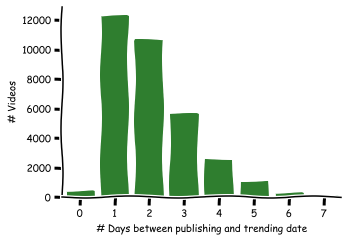

In [26]:
with plt.xkcd():
    fig = plt.figure(figsize=(5,3.5))
    ax = fig.gca()
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot days to trending distribution
    sns.countplot(df.loc[~(is_outlier(df['days_to_trending'].values)),'days_to_trending'],
                 color='forestgreen', ax=ax)
    ax.set_ylabel('# Videos')
    ax.set_xlabel('# Days between publishing and trending date')
    change_fontsize_plot(ax, 10)
    # change_width_bars(ax, 0.4)
    # ax.set_title('The first 3 days since release are critical for a video, with almost all of them trending in less than a week since release')

(5.5, -0.5)

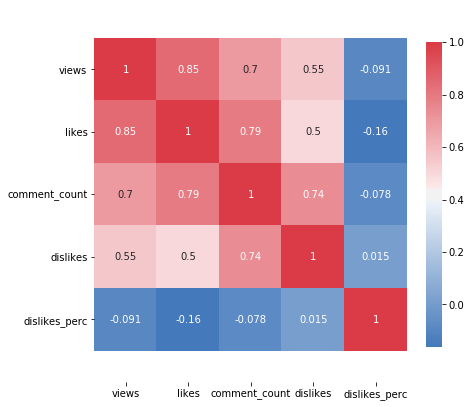

In [27]:
# correlation plot between views, likes, comments, dislikes
corr_metrics = df[['views', 'likes', 'comment_count', 'dislikes', 'dislikes_perc']].corr()

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(7,7))

# Add diverging colormap from red to blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# plot
_ = sns.heatmap(corr_metrics, 
                xticklabels=corr_metrics.columns,
                yticklabels=corr_metrics.columns,
                annot=True, square=True, cmap=cmap, ax=ax,
                cbar_kws={"shrink": .8})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

- Comments, likes and views are highly correlated. Hence we can use only one of these to measure popularity of the video
- % dislikes might be a good metric to measure sentiment of veiwers towards the video

In [28]:
df['category_title'].value_counts()

Entertainment           14764
News & Politics          4709
Music                    3292
Comedy                   2967
People & Blogs           2367
Film & Animation         1463
Education                1166
Howto & Style             801
Sports                    646
Science & Technology      517
Shows                     149
Autos & Vehicles           69
Gaming                     55
Movies                     10
Travel & Events             8
Pets & Animals              3
Name: category_title, dtype: int64

choose top 7 categories for summaries - at least 500 videos

In [29]:
top_categories = df['category_title'].value_counts()[:7].index.values

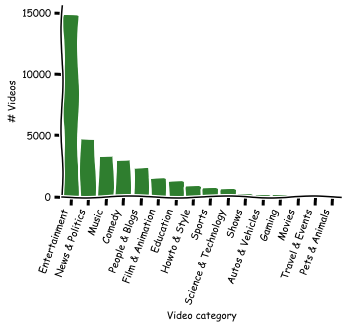

In [30]:
with plt.xkcd():
    fig = plt.figure(figsize=(5,3.5))
    ax = fig.gca()
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot days to trending distribution
    sns.countplot(x=df['category_title'],
                 color='forestgreen'
                 , order=df['category_title'].value_counts().index.values.tolist()
                 , ax=ax)
    ax.set_ylabel('# Videos', fontdict = {'fontsize': 10})
    ax.set_xlabel('Video category', fontdict = {'fontsize': 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
    change_fontsize_plot(ax, 10)
    # ax.set_title('The first 3 days since release are critical for a video, with almost all of them trending in less than a week since release')
    plt.show()

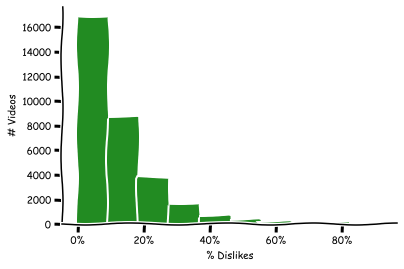

In [31]:
with plt.xkcd():
    fig = plt.figure()
    ax = fig.gca()
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot days to trending distribution
    plt.hist(df.loc[~(np.isnan(df['dislikes_perc'].values)),'dislikes_perc'],
                 color='forestgreen')
    ax.set_ylabel('# Videos')
    ax.set_xlabel('% Dislikes')
    change_fontsize_plot(ax, 10)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    # ax.set_title('The first 3 days since release are critical for a video, with almost all of them trending in less than a week since release')

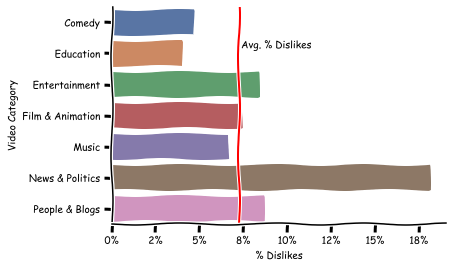

In [32]:
# dislikes by category
temp_subset_cols = ['category_title','likes','dislikes']
df_cat_dislikes = df.query('category_title in @top_categories')[temp_subset_cols].groupby('category_title').sum().reset_index()
df_cat_dislikes.eval('perc_dislikes = dislikes/(likes + dislikes)', inplace=True)
perc_dislikes_overall = df['dislikes'].sum()/(df['likes'].sum() + df['dislikes'].sum())

with plt.xkcd():
    fig = plt.figure()
    ax = fig.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.barplot(data=df_cat_dislikes, x='perc_dislikes', y='category_title',
                orient="h", ax=ax, palette='deep')
    # df_cat_dislikes.plot(kind='barh', x='perc_dislikes', y='category_title', ax=ax)
    plt.axvline(x=perc_dislikes_overall, color='r', linestyle='-')
    ax.annotate('Avg. % Dislikes', xy=(perc_dislikes_overall+0.001, 0.75),
                ha="left", va="center", fontsize = 10)
    change_fontsize_plot(ax, 10)
    ax.set_ylabel('Video Category')
    ax.set_xlabel('% Dislikes')
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.set_facecolor('white')


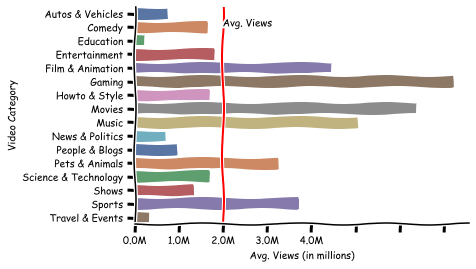

In [33]:
# Average views by category title
temp_subset_cols = ['category_title','views']
df_cat_views = df[temp_subset_cols].groupby('category_title').mean().reset_index()
avg_views_overall = df['views'].mean()

with plt.xkcd():
    fig = plt.figure()
    ax = fig.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.barplot(data=df_cat_views, x='views', y='category_title',
                orient="h", ax=ax, palette='deep')
    # df_cat_dislikes.plot(kind='barh', x='perc_dislikes', y='category_title', ax=ax)
    plt.axvline(x=avg_views_overall, color='r', linestyle='-')
    ax.annotate('Avg. Views', xy=(avg_views_overall+0.001, 0.75),
                ha="left", va="center", fontsize = 10)
    change_fontsize_plot(ax, 10)
    ax.set_ylabel('Video Category')
    ax.set_xlabel('Avg. Views (in millions)')
    ax.set_xticklabels(['{:,.1f}'.format(x/1000000)+'M' for x in ax.get_xticks()])
    ax.set_facecolor('white')

In [40]:
# preprocess tag frequencies
cutoff_tag_frequency = 0.05
tag_text = t.columns.values[(tag_word_total_occurences.sum(axis=0)>df.shape[0]*cutoff_tag_frequency)]
tag_freq = tag_word_total_occurences.sum(axis=0)[(tag_word_total_occurences.sum(axis=0)>df.shape[0]*cutoff_tag_frequency)]
dict_tag_freq = dict(zip(tag_text, tag_freq))

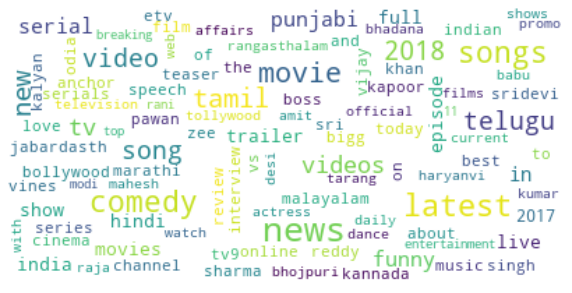

In [47]:
# create wordcloud of tags
wc = WordCloud(max_font_size=25, background_color='white').\
        generate_from_frequencies(dict_tag_freq)
plt.figure(figsize=(10,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### AutoViz

Imported AutoViz_Class version: 0.0.67. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'
Shape of your Data Set: (33089, 13)
Classifying variables in data set...
    12 Predictors classified...
        This does not include the Target column(s)
    6 variables removed since they were ID or low-information variables
    List of variables removed: ['title', 'tags', 'description', 'video_id', 'channel_title', 'thumbnail_link']
Nothing to add Plot not being added
Nothing to add Plot not being added
All Plots done
Time to run AutoViz (in seconds) = 2.266


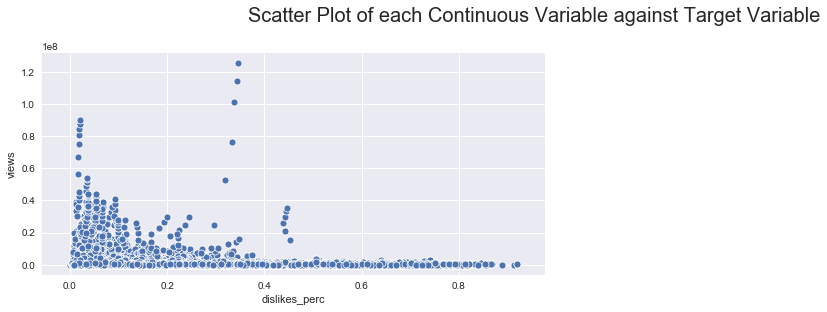

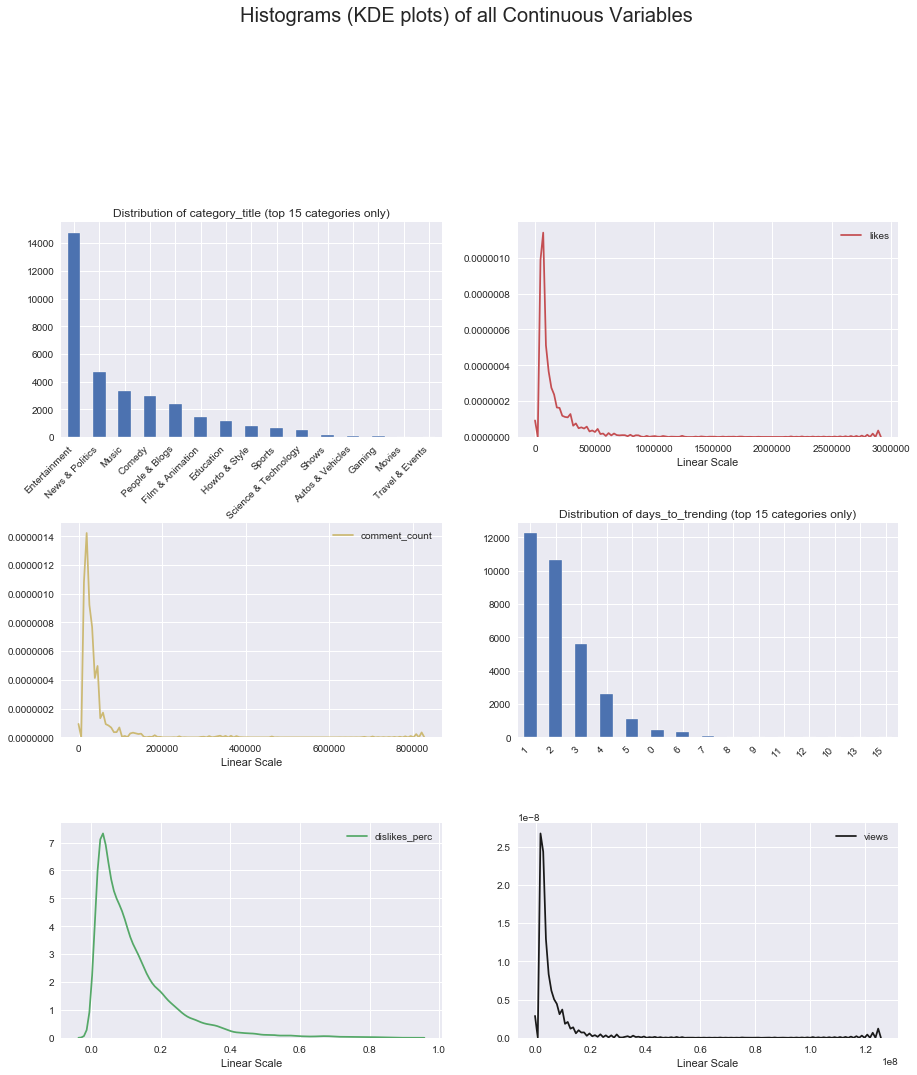

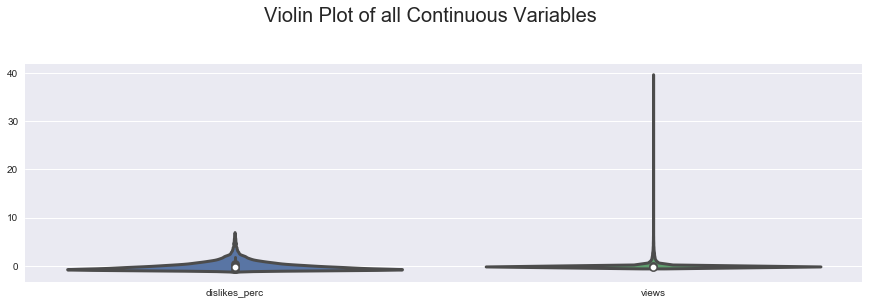

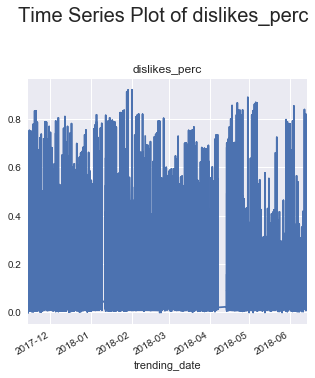

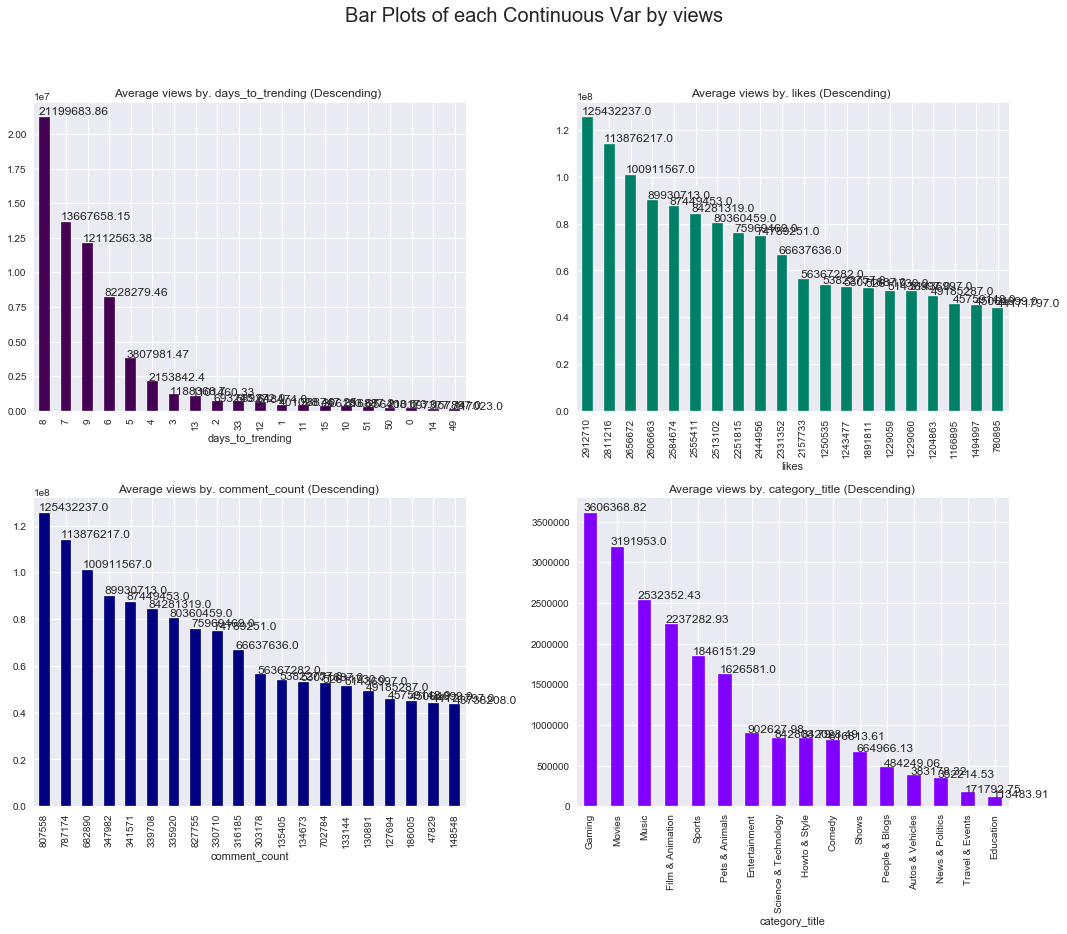

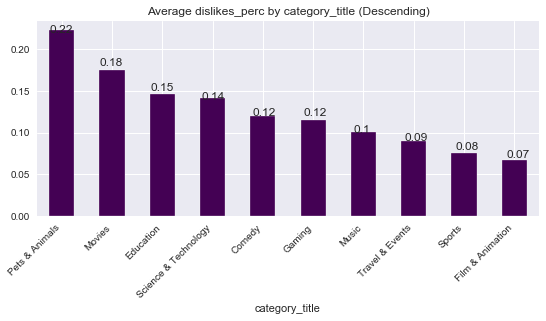

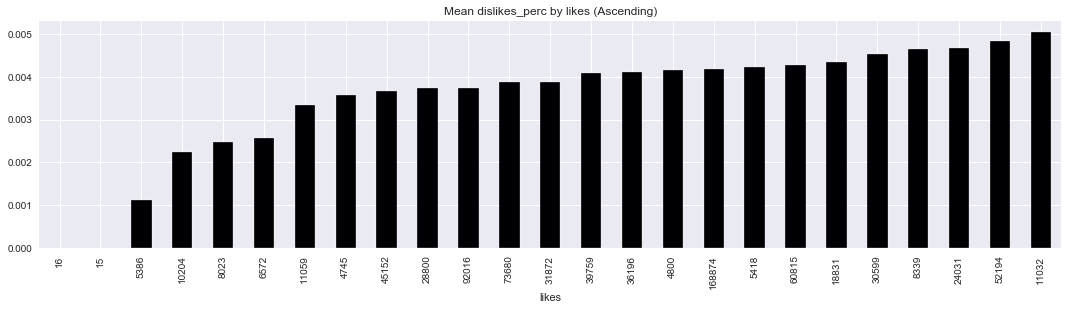

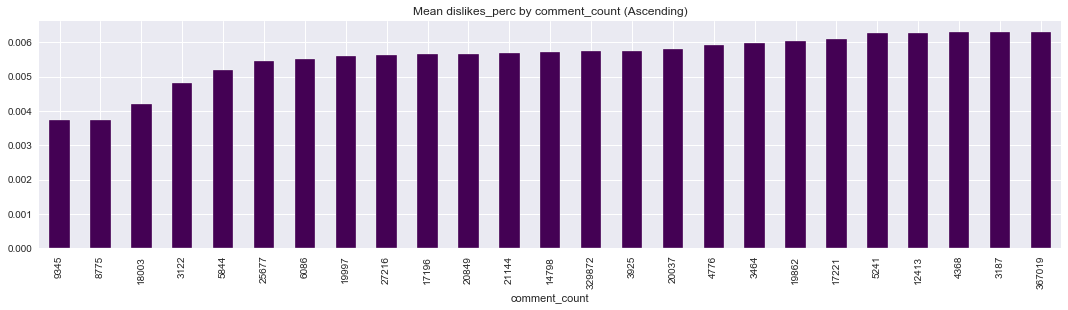

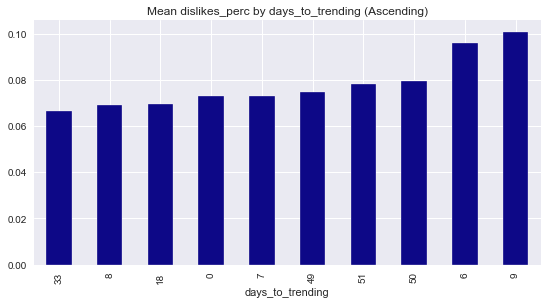

In [35]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
drop_cols_viz = ['comments_disabled', 'ratings_disabled', 'publish_time', 'category_id', 'dislikes', 'video_error_or_removed']
dft = AV.AutoViz('',dfte=df.drop(columns=drop_cols_viz), verbose=100,
                 lowess=False, chart_format='svg', depVar='views')